In [1]:
import chaospy
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import minimize
from sklearn.metrics import r2_score
from scipy.special import kl_div

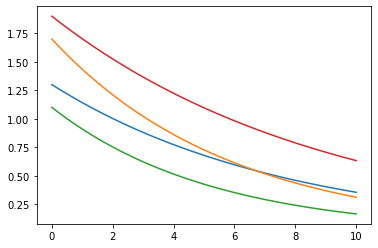

In [2]:
coordinates = np.linspace(0, 10, 1000)


def model_solver(parameters):
    alpha, beta, coordinates = parameters
    return alpha * np.e ** (-coordinates * beta)


for params in [(1.3, 0.13), (1.7, 0.17), (1.1, 0.19), (1.9, 0.11)]:
    samples = [(*params, coordinate) for coordinate in coordinates]
    plt.plot(coordinates, [model_solver(i) for i in samples])

In [3]:
alpha = chaospy.Normal(1.5, 0.2)
beta = chaospy.Uniform(0.1, 0.2)
gamma = chaospy.Uniform(0, 10)
joint = chaospy.J(alpha, beta, gamma)


order = 2
expansion = chaospy.generate_expansion(order, joint)
expansion.shape

(10,)

In [4]:
samples = joint.sample(1000, rule="sobol")
evaluations = np.array([model_solver(sample) for sample in samples.T])
evaluations.shape

(1000,)

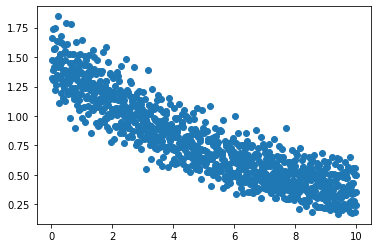

In [5]:
approx_solver = chaospy.fit_regression(expansion, samples, evaluations)

plt.scatter(samples[2], approx_solver(*samples))

Text(0.5, 1.0, 'order=2,r2=0.99925')

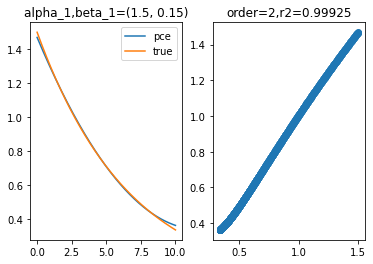

In [6]:
length = coordinates.shape[0]
alpha_1, beta_1 = 1.5, 0.15
test_1 = np.vstack([[alpha_1] * length, [beta_1] * length, coordinates])

ax1 = plt.subplot(1, 2, 1)
ax1.plot(coordinates, approx_solver(*test_1), label="pce")
ax1.plot(coordinates, [model_solver(i) for i in test_1.T], label="true")
ax1.legend()
ax1.set_title(f"{alpha_1,beta_1=}")
ax2 = plt.subplot(1, 2, 2)
ax2.scatter([model_solver(i) for i in test_1.T], approx_solver(*test_1))
r2 = r2_score([model_solver(i) for i in test_1.T], approx_solver(*test_1)).round(5)
ax2.set_title(f"{order=},{r2=}")

In [7]:
n_samples, location = 1_000_000, 5
test = np.vstack([joint.sample(n_samples)[:2], np.ones(n_samples) * location])
pce_sampes = approx_solver(*test)
# plt.hist(pce_sampes, bins=20, density=True)

dist = chaospy.GaussianKDE(pce_sampes)

(array([2.93219300e-04, 2.82870383e-03, 2.19052065e-02, 1.12440977e-01,
        4.25185233e-01, 1.07837434e+00, 1.96067122e+00, 2.67885152e+00,
        2.88572636e+00, 2.61035894e+00, 2.09555210e+00, 1.51442594e+00,
        9.54377077e-01, 5.24707313e-01, 2.46079985e-01, 9.53652652e-02,
        3.06500409e-02, 8.34812595e-03, 1.65582663e-03, 3.96708465e-04]),
 array([0.19523048, 0.25320756, 0.31118464, 0.36916173, 0.42713881,
        0.4851159 , 0.54309298, 0.60107006, 0.65904715, 0.71702423,
        0.77500132, 0.8329784 , 0.89095549, 0.94893257, 1.00690965,
        1.06488674, 1.12286382, 1.18084091, 1.23881799, 1.29679507,
        1.35477216]),
 <BarContainer object of 20 artists>)

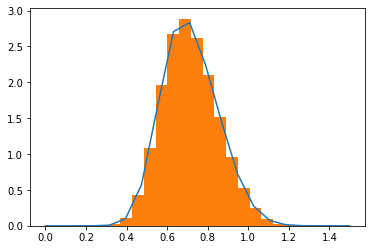

In [8]:
t = np.linspace(0, 1.5, 20)
plt.plot(t, dist.pdf(t))
plt.hist(pce_sampes, bins=20, density=True)

In [9]:
coeff = approx_solver.coefficients
indet = approx_solver.indeterminants
expon = approx_solver.exponents


def f0(coeff):
    pce_model = chaospy.sum(coeff * chaospy.prod(indet ** expon, axis=1))
    n_samples, location = 1_000, 5
    test = np.vstack([joint.sample(n_samples)[:2], np.ones(n_samples) * location])
    pce_sampes = pce_model(*test)

    return chaospy.GaussianKDE(pce_sampes)

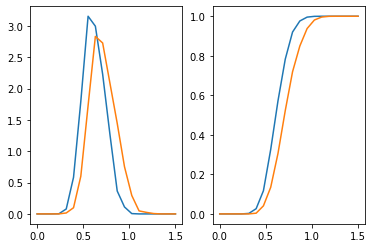

In [10]:
x0 = [i * 0.86 for i in coeff]

plt.subplot(1, 2, 1)
plt.plot(t, f0(x0).pdf(t))
plt.plot(t, f0(coeff).pdf(t))
plt.subplot(1, 2, 2)
plt.plot(t, f0(x0).cdf(t))
plt.plot(t, f0(coeff).cdf(t))

In [11]:
exp = np.asarray([0.3, 0.5, 0.55, 0.6, 0.7, 0.95])
exp.sort()

y_cum = np.arange(1, len(exp) + 1) / len(exp)

# plt.hist(exp, cumulative=True, density=True, histtype="step")
# plt.plot(t, dist.cdf(t))
# plt.scatter(exp, y_cum)


def exp_cdf(x, epsilon):
    # epsilon = 0.1
    for i in range(len(exp)):
        if i == len(exp) - 1:
            return 1
        if x < exp[0]:
            return 0
        if (x >= exp[i]) & (x < exp[i + 1]):
            return max(min(y_cum[i] + epsilon, 1), 0)

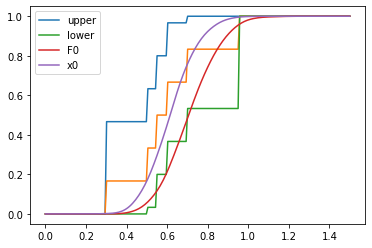

In [12]:
t = np.linspace(0, 1.5, 200)
plt.plot(t, [exp_cdf(i, 0.3) for i in t], label="upper")
plt.plot(t, [exp_cdf(i, 0) for i in t])
plt.plot(t, [exp_cdf(i, -0.3) for i in t], label="lower")
# plt.hist(exp, cumulative=True, density=True, histtype="step")
plt.plot(t, f0(coeff).cdf(t), label="F0")
plt.plot(t, f0(x0).cdf(t), label="x0")
plt.legend()

In [13]:
def obj_func(x, exp=0):
    t = np.linspace(0, 1.5, 20)
    SMALL = 1e-10
    # return kl_divergence(f0(x).pdf(t) + SMALL, f0(coeff).pdf(t) + SMALL)
    return sum(kl_div(f0(x).pdf(t) + SMALL, f0(coeff).pdf(t) + SMALL)) / len(t)


print(f"{obj_func(x0)=},{obj_func(coeff)=}")

obj_func(x0)=0.18123383958846978,obj_func(coeff)=0.009208911315360491


In [14]:
cons = (
    {
        "type": "ineq",
        "fun": lambda x, exp: exp_cdf(exp[0], epsilon=0.3) - f0(x).cdf(exp[0]),
        "args": (exp,),
    },
    {
        "type": "ineq",
        "fun": lambda x, exp: f0(x).cdf(exp[0]) - exp_cdf(exp[0], epsilon=-0.3),
        "args": (exp,),
    },
    {
        "type": "ineq",
        "fun": lambda x, exp: exp_cdf(exp[1], epsilon=0.3) - f0(x).cdf(exp[1]),
        "args": (exp,),
    },
    {
        "type": "ineq",
        "fun": lambda x, exp: f0(x).cdf(exp[1]) - exp_cdf(exp[1], epsilon=-0.3),
        "args": (exp,),
    },
    {
        "type": "ineq",
        "fun": lambda x, exp: exp_cdf(exp[2], epsilon=0.3) - f0(x).cdf(exp[2]),
        "args": (exp,),
    },
    {
        "type": "ineq",
        "fun": lambda x, exp: f0(x).cdf(exp[2]) - exp_cdf(exp[2], epsilon=-0.3),
        "args": (exp,),
    },
)

In [15]:
# res = minimize(obj_func, x0, args=(exp), method="trust-constr", constraints=cons,)
res = minimize(obj_func, x0, args=(exp), method="COBYLA", constraints=cons,)
res

     fun: 0.1308029047861044
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 99
  status: 1
 success: True
       x: array([ 8.55191952e-02, -3.70363435e-02,  2.02169342e-03, -1.20188047e-02,
       -2.69720392e-01,  7.63259400e+00,  1.02994141e+00, -5.63462244e-02,
       -1.68450446e+00, -1.44968787e-02])

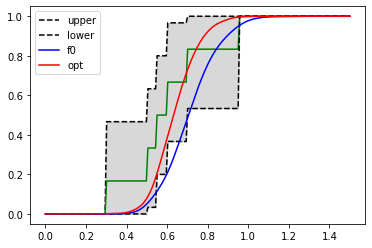

In [16]:
plt.plot(t, [exp_cdf(i, 0.3) for i in t], "k--", label="upper")
plt.plot(t, [exp_cdf(i, 0) for i in t], "g")
plt.plot(t, [exp_cdf(i, -0.3) for i in t], "k--", label="lower")
plt.fill_between(
    t,
    [exp_cdf(i, 0.3) for i in t],
    [exp_cdf(i, -0.3) for i in t],
    alpha=0.3,
    color="grey",
)

plt.plot(t, f0(coeff).cdf(t), "b", label="f0")
plt.plot(t, f0(res.x).cdf(t), "r", label="opt")
# plt.plot(t, f0(x0).cdf(t), label="init")
plt.legend()

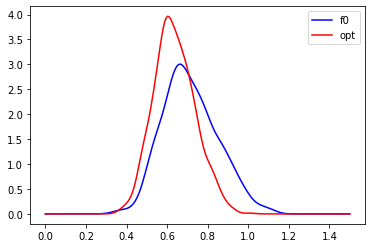

In [17]:
plt.plot(t, f0(coeff).pdf(t), "b", label="f0")
plt.plot(t, f0(res.x).pdf(t), "r", label="opt")
# plt.plot(t, f0(x0).pdf(t), label="init")
plt.legend()